In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score,f1_score, accuracy_score
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation, Flatten, Input
from keras.layers.normalization import BatchNormalization
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
cols = ['sentiment','id','date','query_string','user','text']
p = 0.2
data = pd.read_csv("data/train.csv",header=None, names=cols, encoding = "ISO-8859-1",
                   skiprows=lambda i: i>0 and random.random() > p)

In [3]:
file_before = open("before.txt", "w")
for row in data['text'].head(20):
    file_before.write(row)
    file_before.write("\n")
file_before.close()
data.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467812579,Mon Apr 06 22:20:17 PDT 2009,NO_QUERY,pardonlauren,I just re-pierced my ears
2,0,1467812723,Mon Apr 06 22:20:19 PDT 2009,NO_QUERY,TLeC,@caregiving I couldn't bear to watch it. And ...
3,0,1467812784,Mon Apr 06 22:20:20 PDT 2009,NO_QUERY,bayofwolves,"@smarrison i would've been the first, but i di..."
4,0,1467812964,Mon Apr 06 22:20:22 PDT 2009,NO_QUERY,lovesongwriter,Hollis' death scene will hurt me severely to w...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320815 entries, 0 to 320814
Data columns (total 6 columns):
sentiment       320815 non-null int64
id              320815 non-null int64
date            320815 non-null object
query_string    320815 non-null object
user            320815 non-null object
text            320815 non-null object
dtypes: int64(2), object(4)
memory usage: 14.7+ MB


In [5]:
data['query_string'].value_counts()

NO_QUERY    320815
Name: query_string, dtype: int64

*query_string is a constant column so we can drop that. id, date and user columns does not also help
in finding the tweet sentiment.*

In [6]:
data.drop(['id','date','query_string','user'],axis=1,inplace=True)

In [7]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,I just re-pierced my ears
2,0,@caregiving I couldn't bear to watch it. And ...
3,0,"@smarrison i would've been the first, but i di..."
4,0,Hollis' death scene will hurt me severely to w...


In [8]:
data['sentiment'].value_counts()

0    160609
4    160206
Name: sentiment, dtype: int64

In [9]:
data.loc[data['sentiment']> 0, ['sentiment']] = 1

In [10]:
data['sentiment'].value_counts()

0    160609
1    160206
Name: sentiment, dtype: int64

# Data Preprocessing

In [11]:
#let's remove stopwords
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself'
             , 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself','they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that',
             "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
             'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'for','with', 'about', 'between', 'through', 'during', 'before', 'after', 'below',
             'to', 'from', 'up', 'in', 'out', 'on', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all','both', 'each', 'more', 'just', 'at',
             'most', 'other', 'some', 'such', 'same', 'so', 'than', 'very', 's', 't', 'can', 'will', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y']

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in (stopwords)]))

In [12]:
# make all the words lower case and decode html
from bs4 import BeautifulSoup
data['text'] = data['text'].apply(lambda x: BeautifulSoup(x.lower(), 'lxml').get_text())

In [13]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - awww, t..."
1,0,re-pierced ears
2,0,@caregiving couldn't bear watch it. thought ua...
3,0,"@smarrison would've first, didn't gun. not rea..."
4,0,hollis' death scene hurt severely watch film w...


In [14]:
#remove @usernames and #hashtags
import re,string

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

data['text'] = data['text'].apply(strip_all_entities)

In [15]:
# keep only alphabets
data['text'] =data['text'].apply(lambda x: re.sub("[^a-z]", " ", x))

In [16]:
file_after = open("after.txt", "w")
for row in data['text'].head(20):
    file_after.write(row)
    file_after.write("\n")
file_after.close()

# Words Visualization

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(max_features=10000)
cvec.fit(data.text)

document_matrix = cvec.transform(data.text)



    

In [18]:
data['sentiment'].value_counts()[0]
data.shape[0]

320815

In [19]:
neg_batches = np.linspace(0,data['sentiment'].value_counts()[0],10).astype(int)
i=0
neg_tf = []

while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    print (neg_batches[i+1],"entries' term freuquency calculated")
    i += 1

pos_batches = np.linspace(data['sentiment'].value_counts()[0] + 1 ,data.shape[0], 10).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    print (pos_batches[i+1],"entries' term freuquency calculated")
    i += 1


17845 entries' term freuquency calculated
35690 entries' term freuquency calculated
53536 entries' term freuquency calculated
71381 entries' term freuquency calculated
89227 entries' term freuquency calculated
107072 entries' term freuquency calculated
124918 entries' term freuquency calculated
142763 entries' term freuquency calculated
160609 entries' term freuquency calculated
178410 entries' term freuquency calculated
196211 entries' term freuquency calculated
214011 entries' term freuquency calculated
231812 entries' term freuquency calculated
249612 entries' term freuquency calculated
267413 entries' term freuquency calculated
285213 entries' term freuquency calculated
303014 entries' term freuquency calculated
320815 entries' term freuquency calculated


In [20]:
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
not,15003,6742,21745
good,5882,12395,18277
day,8300,9631,17931
get,9137,7278,16415
like,8387,7615,16002
no,10934,4659,15593
go,9081,5717,14798
http,4921,9514,14435
today,7686,6112,13798
too,7429,5669,13098


Text(0.5,1,'Top 30 tokens in negative tweets')

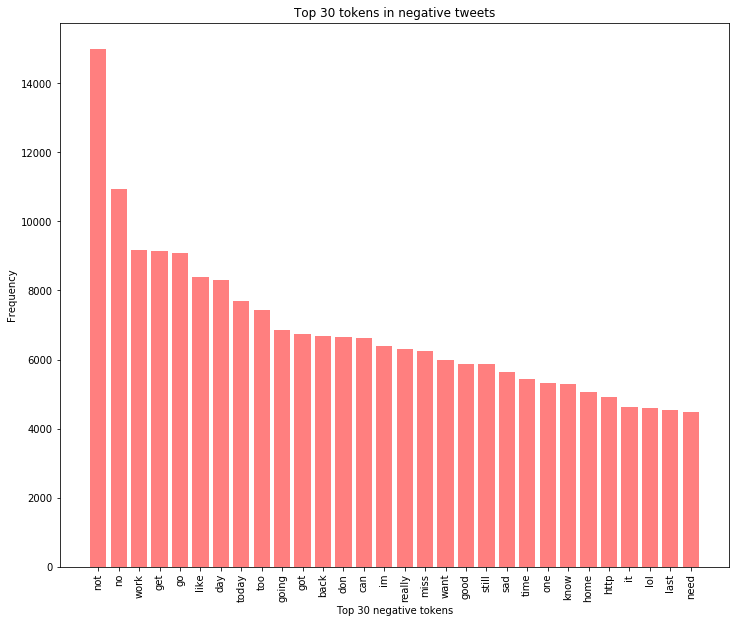

In [21]:
y_pos = np.arange(30)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:30], align='center', alpha=0.5, color='red')
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:30].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 30 negative tokens')
plt.title('Top 30 tokens in negative tweets')

Text(0.5,1,'Top 30 tokens in positive tweets')

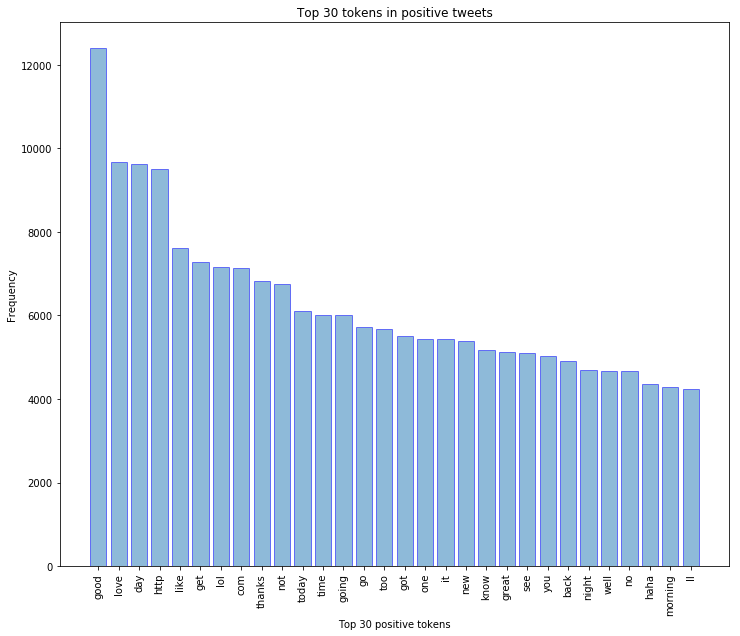

In [22]:
y_pos = np.arange(30)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:30], align='center', alpha=0.5, edgecolor='blue')
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:30].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 30 positive tokens')
plt.title('Top 30 tokens in positive tweets')

# Data Splitting

In [23]:
from sklearn.model_selection import train_test_split
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(data.text
, data.sentiment, test_size=.04, random_state=100)
x_validation, x_test, y_validation, y_test =  train_test_split(x_validation_and_test,
y_validation_and_test, test_size=.5, random_state=100)

In [24]:
print(x_train.shape, x_train[y_train>0].shape, x_train[y_train==0].shape)
print(x_validation.shape, x_validation[y_validation>0].shape, x_validation[y_validation==0].shape)
print(x_test.shape, x_test[y_test>0].shape, x_test[y_test==0].shape)

(307982,) (153815,) (154167,)
(6416,) (3172,) (3244,)
(6417,) (3219,) (3198,)


# Count Vectorization

In [25]:
def eval_metric(prediction, truth):
    print("accuracy:     {}".format(accuracy_score(prediction, truth)))
    print("recall:       {}".format(recall_score(prediction, truth)))
    print("precision:    {}".format(precision_score(prediction, truth)))
    print("f1_score:     {}".format(f1_score(prediction, truth)))
    print("\nconfusion_matrix:\n",confusion_matrix(prediction, truth))

In [26]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

CVec = CountVectorizer()
num_of_features = [1000, 10000, 20000, 50000]
for n_features in num_of_features:
    
    CVec.set_params(max_features = n_features)
    CVec.fit(x_train)
    
    x_train_vector = CVec.transform(x_train)
    x_validation_vector = CVec.transform(x_validation)
    
    logreg = LogisticRegression()
    logreg.fit(x_train_vector, y_train)
    lr_prediction = logreg.predict(x_validation_vector)
    eval_metric(lr_prediction, y_validation)

accuracy:     0.753428927680798
recall:       0.7285796434732605
precision:    0.7988650693568726
f1_score:     0.7621052631578948

confusion_matrix:
 [[2300  638]
 [ 944 2534]]
accuracy:     0.7797693266832918
recall:       0.7624589674723963
precision:    0.8054854981084489
f1_score:     0.783381879503296

confusion_matrix:
 [[2448  617]
 [ 796 2555]]
accuracy:     0.7810162094763092
recall:       0.7636526410026858
precision:    0.8067465321563683
f1_score:     0.7846083090602484

confusion_matrix:
 [[2452  613]
 [ 792 2559]]
accuracy:     0.7822630922693267
recall:       0.7664365055538878
precision:    0.8048549810844893
f1_score:     0.7851760725818852

confusion_matrix:
 [[2466  619]
 [ 778 2553]]


# Word2Vec

In [27]:
# This function converts a text to a sequence of words.
def wordlist(sentence):
    words = sentence.lower().split()
    return(words)

tweets = []
for tweet in x_train:
    tweets.append(wordlist(tweet))
print(len(tweets))

307982


In [28]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [29]:
# Creating the model and setting values for the various parameters
num_features = 300  # Word vector dimensionality
min_word_count = 40 # Minimum word count
num_workers = 4     # Number of parallel threads
context = 10        # Context window size
downsampling = 1e-3 # (0.001) Downsample setting for frequent words

# Initializing the train model
from gensim.models import word2vec
print("Training model....")
model = word2vec.Word2Vec(tweets,\
                          workers=num_workers,\
                          size=num_features,\
                          min_count=min_word_count,\
                          window=context,
                          sample=downsampling)

# To make the model memory efficient
model.init_sims(replace=True)

# Saving the model for later use. Can be loaded using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

2018-12-04 11:40:52,301 : INFO : 'pattern' package not found; tag filters are not available for English
2018-12-04 11:40:52,358 : INFO : collecting all words and their counts
2018-12-04 11:40:52,359 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-12-04 11:40:52,391 : INFO : PROGRESS: at sentence #10000, processed 83573 words, keeping 13677 word types
2018-12-04 11:40:52,411 : INFO : PROGRESS: at sentence #20000, processed 166143 words, keeping 20856 word types
2018-12-04 11:40:52,429 : INFO : PROGRESS: at sentence #30000, processed 249909 words, keeping 26684 word types
2018-12-04 11:40:52,447 : INFO : PROGRESS: at sentence #40000, processed 333379 words, keeping 31605 word types
2018-12-04 11:40:52,464 : INFO : PROGRESS: at sentence #50000, processed 416537 words, keeping 35905 word types
2018-12-04 11:40:52,481 : INFO : PROGRESS: at sentence #60000, processed 499085 words, keeping 40062 word types
2018-12-04 11:40:52,501 : INFO : PROGRESS: at sentence 

Training model....


2018-12-04 11:40:52,554 : INFO : PROGRESS: at sentence #100000, processed 832117 words, keeping 54318 word types
2018-12-04 11:40:52,572 : INFO : PROGRESS: at sentence #110000, processed 914643 words, keeping 57525 word types
2018-12-04 11:40:52,589 : INFO : PROGRESS: at sentence #120000, processed 997874 words, keeping 60755 word types
2018-12-04 11:40:52,607 : INFO : PROGRESS: at sentence #130000, processed 1081334 words, keeping 63890 word types
2018-12-04 11:40:52,624 : INFO : PROGRESS: at sentence #140000, processed 1164562 words, keeping 66759 word types
2018-12-04 11:40:52,642 : INFO : PROGRESS: at sentence #150000, processed 1248208 words, keeping 69523 word types
2018-12-04 11:40:52,659 : INFO : PROGRESS: at sentence #160000, processed 1331121 words, keeping 72273 word types
2018-12-04 11:40:52,677 : INFO : PROGRESS: at sentence #170000, processed 1414114 words, keeping 74956 word types
2018-12-04 11:40:52,694 : INFO : PROGRESS: at sentence #180000, processed 1497247 words, ke

In [30]:
model.wv.doesnt_match("man woman dog child kitchen".split())

'man'

In [31]:
model.wv.most_similar("hand")

[('finger', 0.8173677325248718),
 ('hole', 0.7178037166595459),
 ('shoulder', 0.7099558115005493),
 ('wrist', 0.7098051309585571),
 ('foot', 0.7044979929924011),
 ('toilet', 0.7042155265808105),
 ('toe', 0.6926454305648804),
 ('bathroom', 0.6909935474395752),
 ('nail', 0.6907315254211426),
 ('arm', 0.6874572038650513)]

In [32]:
model.wv.most_similar("awful")

[('terrible', 0.8955605626106262),
 ('horrible', 0.8378608226776123),
 ('icky', 0.7210493683815002),
 ('shitty', 0.7205473780632019),
 ('poorly', 0.7158030271530151),
 ('crappy', 0.6695282459259033),
 ('painful', 0.6634743809700012),
 ('gross', 0.6593185663223267),
 ('infection', 0.6592518091201782),
 ('guilty', 0.6553943753242493)]

In [33]:
model.wv.syn0.shape

(5162, 300)

In [34]:
# Function to average all word vectors in a paragraph
def featureVecMethod(words, model, num_features):
    # Pre-initialising empty numpy array for speed
    featureVec = np.zeros(num_features,dtype="float64")
    nwords = 0
    
    #Converting Index2Word which is a list to a set for better speed in the execution.
    index2word_set = set(model.wv.index2word)
    
    for word in  words:
        if word in index2word_set:
            nwords = nwords + 1
            featureVec = np.add(featureVec,model[word])
    # Dividing the result by number of words to get average
    featureVec = np.divide(featureVec, nwords)
    featureVec[np.isnan(featureVec)] = 0
#     print(np.argwhere(np.isnan(featureVec)))
    
    return featureVec

# Function for calculating the average feature vector
def getAvgFeatureVecs(tweets, model, num_features):
    counter = 0
    tweetFeatureVecs = np.zeros((len(tweets),num_features),dtype="float64")
    for tweet in tweets:
        # Printing a status message every 1000th tweet
        if counter%1000 == 0:
            print("Review %d of %d"%(counter,len(tweets)))
            
        tweetFeatureVecs[counter] = featureVecMethod(tweet, model, num_features)
        counter = counter+1
        
    return tweetFeatureVecs

# Calculating average feature vector for training set
train_tweets = []
for tweet in x_train:
    train_tweets.append(wordlist(tweet))

validation_tweets = []
for tweet in x_validation:
    validation_tweets.append(wordlist(tweet))

trainDataVecs = getAvgFeatureVecs(train_tweets, model, num_features)
validationDataVecs =  getAvgFeatureVecs(validation_tweets, model, num_features)

Review 0 of 307982
Review 1000 of 307982
Review 2000 of 307982
Review 3000 of 307982
Review 4000 of 307982
Review 5000 of 307982
Review 6000 of 307982
Review 7000 of 307982
Review 8000 of 307982
Review 9000 of 307982
Review 10000 of 307982
Review 11000 of 307982
Review 12000 of 307982
Review 13000 of 307982
Review 14000 of 307982
Review 15000 of 307982
Review 16000 of 307982
Review 17000 of 307982
Review 18000 of 307982
Review 19000 of 307982
Review 20000 of 307982
Review 21000 of 307982
Review 22000 of 307982
Review 23000 of 307982
Review 24000 of 307982
Review 25000 of 307982
Review 26000 of 307982
Review 27000 of 307982
Review 28000 of 307982
Review 29000 of 307982
Review 30000 of 307982
Review 31000 of 307982
Review 32000 of 307982
Review 33000 of 307982
Review 34000 of 307982
Review 35000 of 307982
Review 36000 of 307982
Review 37000 of 307982
Review 38000 of 307982
Review 39000 of 307982
Review 40000 of 307982
Review 41000 of 307982
Review 42000 of 307982
Review 43000 of 307982
R

In [35]:
logreg = LogisticRegression()
logreg.fit(trainDataVecs, y_train)
lr_prediction = logreg.predict(validationDataVecs)
eval_metric(lr_prediction, y_validation)

accuracy:     0.7479738154613467
recall:       0.7391571824054137
precision:    0.7575662042875158
f1_score:     0.7482484820177487

confusion_matrix:
 [[2396  769]
 [ 848 2403]]


In [36]:
type(trainDataVecs)
print(trainDataVecs.shape)
print(y_train.shape)
print(np.argwhere(np.isnan(trainDataVecs)).shape)
a = np.argwhere(np.isnan(trainDataVecs))

for i in a:
     print (i[0])

(307982, 300)
(307982,)
(0, 2)


# CNN

In [37]:
from gensim.models import KeyedVectors
model_w2v = KeyedVectors.load(model_name)

embeddings_index = {}
for w in model_w2v.wv.vocab.keys():
    embeddings_index[w] = model_w2v.wv[w]


2018-12-04 11:42:57,040 : INFO : loading Word2VecKeyedVectors object from 300features_40minwords_10context
2018-12-04 11:42:57,144 : INFO : loading wv recursively from 300features_40minwords_10context.wv.* with mmap=None
2018-12-04 11:42:57,144 : INFO : setting ignored attribute vectors_norm to None
2018-12-04 11:42:57,144 : INFO : loading vocabulary recursively from 300features_40minwords_10context.vocabulary.* with mmap=None
2018-12-04 11:42:57,145 : INFO : loading trainables recursively from 300features_40minwords_10context.trainables.* with mmap=None
2018-12-04 11:42:57,145 : INFO : setting ignored attribute cum_table to None
2018-12-04 11:42:57,146 : INFO : loaded 300features_40minwords_10context


In [38]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

In [39]:
for x in x_train[:5]:
    print (x)
sequences[:5]

no worries didn t want anyone think stealing i m half catholic half jewish lots guilt
bravo i d clapping could hear amandapalmer live http ustre am  qrf
waddup tweeple lazy saturday btw hows weather hyd vry lovely dehradun
sad play com correct won t get tw soundtrack til end july
ahhhh finally own bed


[[10, 1609, 91, 2, 36, 315, 37, 5163, 1, 3, 408, 8966, 408, 12286, 406, 6533],
 [8369, 1, 90, 12287, 87, 225, 14035, 216, 12, 1988, 177, 14036],
 [15204, 3339, 770, 371, 446, 1647, 204, 15205, 13076, 369, 42387],
 [59, 237, 24, 2403, 147, 2, 8, 5577, 4002, 472, 301, 807],
 [1734, 174, 442, 86]]

In [40]:
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq = pad_sequences(sequences_val, maxlen=58)

In [41]:
length = []
for x in x_train:
    length.append(len(x.split()))
max(length)

50

In [42]:
x_train_seq = pad_sequences(sequences, maxlen=58)
x_train_seq[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    10,  1609,    91,
            2,    36,   315,    37,  5163,     1,     3,   408,  8966,
          408, 12286,   406,  6533],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,  8369,     1,    90, 12287,    87,   225, 14035,   216,
           12,  1988,   177, 14036],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
   

In [43]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [44]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [45]:

model_ptw2v = Sequential()
e = Embedding(100000, 300, weights=[embedding_matrix], input_length=58, trainable=False)
model_ptw2v.add(e)
model_ptw2v.add(Flatten())
model_ptw2v.add(Dense(256, activation='relu'))
model_ptw2v.add(Dense(1, activation='sigmoid'))
model_ptw2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 307982 samples, validate on 6416 samples
Epoch 1/5


KeyboardInterrupt: 

In [51]:
lstm_out = 196

model = Sequential()
model.add(Embedding(100000, 300, weights=[embedding_matrix], input_length=58, trainable=False))
model.add(LSTM(lstm_out, recurrent_dropout=0.2, dropout=0.2))
model.add(Dense(9,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_crossentropy'])
model_ptw2v.fit(x_train_seq, y_train, validation_data=(x_val_seq, y_validation), epochs=5, batch_size=32, verbose=2)

Train on 307982 samples, validate on 6416 samples
Epoch 1/5
 - 665s - loss: 0.4690 - acc: 0.7757 - val_loss: 0.4849 - val_acc: 0.7717
Epoch 2/5
 - 674s - loss: 0.4224 - acc: 0.8046 - val_loss: 0.4987 - val_acc: 0.7614
Epoch 3/5
 - 677s - loss: 0.3695 - acc: 0.8352 - val_loss: 0.5225 - val_acc: 0.7604
Epoch 4/5
 - 671s - loss: 0.3183 - acc: 0.8627 - val_loss: 0.5814 - val_acc: 0.7561
Epoch 5/5
 - 664s - loss: 0.2736 - acc: 0.8845 - val_loss: 0.6451 - val_acc: 0.7453
